In [ ]:
# Installs
!pip install -q transformers roboflow opencv-python-headless \
             albumentations scikit-learn matplotlib tqdm pillow

# Imports
import os, random, numpy as np, torch
from PIL import Image
import torch.nn.functional as F
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torchvision.transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
BASE = '/content/drive/MyDrive/drywall-qa'

# Load model from saved checkpoint
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model     = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model     = model.to(DEVICE)
model.load_state_dict(torch.load(f"{BASE}/checkpoints/clipseg_best.pt",
                                  map_location=DEVICE))
model.eval()

print(f"✅ Device  : {DEVICE}")
print(f"✅ Model   : Loaded from checkpoint")
print(f"✅ Ready   : Skip training, run any cell below!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.8 MB/s eta 0:00:00
Mounted at /content/drive


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/462 [00:00<?, ?it/s]

CLIPSegForImageSegmentation LOAD REPORT from: CIDAS/clipseg-rd64-refined
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
clip.text_model.embeddings.position_ids   | UNEXPECTED |  | 
clip.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Device  : cuda
✅ Model   : Loaded from checkpoint
✅ Ready   : Skip training, run any cell below!


In [ ]:
import os
os.makedirs('/content/drive/MyDrive/drywall-qa/data', exist_ok=True)
os.makedirs('/content/drive/MyDrive/drywall-qa/checkpoints', exist_ok=True)
os.makedirs('/content/drive/MyDrive/drywall-qa/predictions', exist_ok=True)

In [ ]:
!pip install -q transformers roboflow opencv-python-headless \
             albumentations scikit-learn matplotlib tqdm pillow torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.2 MB/s eta 0:00:00


In [ ]:
import os

BASE = '/content/drive/MyDrive/drywall-qa'

folders = [
    f'{BASE}/data/dataset1_taping/images',
    f'{BASE}/data/dataset1_taping/masks',
    f'{BASE}/data/dataset2_cracks/images',
    f'{BASE}/data/dataset2_cracks/masks',
    f'{BASE}/checkpoints',
    f'{BASE}/predictions',
]

for f in folders:
    os.makedirs(f, exist_ok=True)

print("All folders created successfully")
print(f"Project root: {BASE}")

✅ All folders created successfully
📁 Project root: /content/drive/MyDrive/drywall-qa


In [ ]:
!nvidia-smi

Fri Feb 20 16:58:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Start with imports

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" Using device: {DEVICE}")
print(f" Seed set to: {SEED}")

✅ Using device: cuda
🌱 Seed set to: 42


Download Dataset 1 (Taping Areas)

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="kNUaGP9qJftCWh6G7uy1")

# Dataset 1: Taping areas — download as COCO (bounding boxes)
project1 = rf.workspace("objectdetect-pu6rn").project("drywall-join-detect")
dataset1 = project1.version(1).download(
    "coco",
    location=f"{BASE}/data/dataset1_taping_raw"
)

print("✅ Dataset 1 (Taping) downloaded in COCO format")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/drive/MyDrive/drywall-qa/data/dataset1_taping_raw in coco:: 100%|██████████| 1192/1192 [00:00<00:00, 8237.83it/s]

✅ Dataset 1 (Taping) downloaded in COCO format


Convert Bounding Boxes to Binary Masks

In [ ]:
import json
import numpy as np
from PIL import Image
import os

def coco_bbox_to_masks(coco_json_path, images_dir, masks_output_dir):
    os.makedirs(masks_output_dir, exist_ok=True)

    with open(coco_json_path, 'r') as f:
        coco = json.load(f)

    # Build a lookup: image_id → image info
    id_to_image = {img['id']: img for img in coco['images']}

    # Build a lookup: image_id → list of annotations
    id_to_anns = {}
    for ann in coco['annotations']:
        img_id = ann['image_id']
        if img_id not in id_to_anns:
            id_to_anns[img_id] = []
        id_to_anns[img_id].append(ann)

    count = 0
    for img_id, img_info in id_to_image.items():
        W, H = img_info['width'], img_info['height']
        mask = np.zeros((H, W), dtype=np.uint8)

        # Draw each bounding box as a filled white region
        if img_id in id_to_anns:
            for ann in id_to_anns[img_id]:
                x, y, w, h = [int(v) for v in ann['bbox']]
                mask[y:y+h, x:x+w] = 255

        # Save mask with same name as image but as PNG
        img_filename = os.path.splitext(img_info['file_name'])[0] + '.png'
        mask_path = os.path.join(masks_output_dir, img_filename)
        Image.fromarray(mask).save(mask_path)
        count += 1

    print(f"✅ Saved {count} masks to {masks_output_dir}")


# Run for train, valid, test splits
for split in ['train', 'valid', 'test']:
    json_path = f"{BASE}/data/dataset1_taping_raw/{split}/_annotations.coco.json"
    images_dir = f"{BASE}/data/dataset1_taping_raw/{split}"
    masks_dir = f"{BASE}/data/dataset1_taping/masks/{split}"

    if os.path.exists(json_path):
        print(f"Processing {split}...")
        coco_bbox_to_masks(json_path, images_dir, masks_dir)
    else:
        print(f"⚠️ No {split} split found, skipping")

Processing train...
✅ Saved 936 masks to /content/drive/MyDrive/drywall-qa/data/dataset1_taping/masks/train
Processing valid...
✅ Saved 250 masks to /content/drive/MyDrive/drywall-qa/data/dataset1_taping/masks/valid
⚠️ No test split found, skipping


confirm  masks were actually created properly

In [ ]:
from PIL import Image
import os

for split in ['train', 'valid']:
    masks_dir = f"{BASE}/data/dataset1_taping/masks/{split}"
    if os.path.exists(masks_dir):
        files = os.listdir(masks_dir)
        print(f"✅ {split}: {len(files)} masks found")


        if files:
            sample = Image.open(os.path.join(masks_dir, files[0]))
            print(f"   Sample mask size: {sample.size}, mode: {sample.mode}")
            unique_vals = set(np.array(sample).flatten())
            print(f" Pixel values in mask: {unique_vals}  ← should be {{0}} or {{0, 255}}")
    else:
        print(f"⚠️ {split} masks folder missing")

✅ train: 936 masks found
   Sample mask size: (640, 640), mode: L
   Pixel values in mask: {np.uint8(0), np.uint8(255)}  ← should be {0} or {0, 255}
✅ valid: 250 masks found
   Sample mask size: (640, 640), mode: L
   Pixel values in mask: {np.uint8(0), np.uint8(255)}  ← should be {0} or {0, 255}


Download Dataset 2

In [ ]:
project2 = rf.workspace("fyp-ny1jt").project("cracks-3ii36")
print(project2)
# # Dataset 2: Cracks
# project2 = rf.workspace("fyp-ny1jt").project("cracks-3ii36")
# dataset2 = project2.version(1).download(
#     "png-mask-semantic",
#     location=f"{BASE}/data/dataset2_cracks_raw"
# )

# print("✅ Dataset 2 (Cracks) downloaded")

loading Roboflow workspace...
loading Roboflow project...
{
  "name": "cracks",
  "type": "object-detection",
  "workspace": "fyp-ny1jt"
}


In [ ]:
project2 = rf.workspace("university-bswxt").project("crack-bphdr")

for v in [1, 2, 3]:
    try:
        print(f"Trying version {v}...")
        dataset2 = project2.version(v).download(
            "coco",
            location=f"{BASE}/data/dataset2_cracks_raw"
        )
        print(f"✅ Downloaded version {v} successfully!")
        break
    except Exception as e:
        print(f"Version {v} failed: {e}")

loading Roboflow workspace...
loading Roboflow project...
Trying version 1...



Extracting Dataset Version Zip to /content/drive/MyDrive/drywall-qa/data/dataset2_cracks_raw in coco:: 100%|██████████| 1557/1557 [00:04<00:00, 327.07it/s]


✅ Downloaded version 1 successfully!


Convert Cracks Bounding Boxes to Masks

In [ ]:
for split in ['train', 'valid', 'test']:
    json_path = f"{BASE}/data/dataset2_cracks_raw/{split}/_annotations.coco.json"
    masks_dir = f"{BASE}/data/dataset2_cracks/masks/{split}"

    if os.path.exists(json_path):
        print(f"Processing {split}...")
        coco_bbox_to_masks(json_path, f"{BASE}/data/dataset2_cracks_raw/{split}", masks_dir)
    else:
        print(f"⚠️ No {split} split found, skipping")

Processing train...
✅ Saved 1239 masks to /content/drive/MyDrive/drywall-qa/data/dataset2_cracks/masks/train
⚠️ No valid split found, skipping
Processing test...
✅ Saved 312 masks to /content/drive/MyDrive/drywall-qa/data/dataset2_cracks/masks/test


Manually Create Train/Valid Split for Dataset 2

In [ ]:
import shutil
from sklearn.model_selection import train_test_split


train_imgs_dir = f"{BASE}/data/dataset2_cracks_raw/train"
train_masks_dir = f"{BASE}/data/dataset2_cracks/masks/train"

all_images = [f for f in os.listdir(train_imgs_dir)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]


valid_images = []
for img_file in all_images:
    mask_file = os.path.splitext(img_file)[0] + '.png'
    if os.path.exists(os.path.join(train_masks_dir, mask_file)):
        valid_images.append(img_file)

print(f"Total images with masks: {len(valid_images)}")

# Split 80% train, 20% valid
train_files, valid_files = train_test_split(
    valid_images,
    test_size=0.2,
    random_state=SEED
)

print(f"New train split: {len(train_files)} images")
print(f"New valid split: {len(valid_files)} images")

Total images with masks: 1239
New train split: 991 images
New valid split: 248 images


In [ ]:

new_train_imgs = f"{BASE}/data/dataset2_cracks/images/train"
new_valid_imgs = f"{BASE}/data/dataset2_cracks/images/valid"
new_train_masks = f"{BASE}/data/dataset2_cracks/masks/train_final"
new_valid_masks = f"{BASE}/data/dataset2_cracks/masks/valid"

for d in [new_train_imgs, new_valid_imgs, new_train_masks, new_valid_masks]:
    os.makedirs(d, exist_ok=True)

# Copy train files
print("Copying train split...")
for img_file in tqdm(train_files):
    # Copy image
    shutil.copy(
        os.path.join(train_imgs_dir, img_file),
        os.path.join(new_train_imgs, img_file)
    )
    # Copy mask
    mask_file = os.path.splitext(img_file)[0] + '.png'
    shutil.copy(
        os.path.join(train_masks_dir, mask_file),
        os.path.join(new_train_masks, mask_file)
    )

# Copy valid files
print("Copying valid split...")
for img_file in tqdm(valid_files):
    # Copy image
    shutil.copy(
        os.path.join(train_imgs_dir, img_file),
        os.path.join(new_valid_imgs, img_file)
    )
    # Copy mask
    mask_file = os.path.splitext(img_file)[0] + '.png'
    shutil.copy(
        os.path.join(train_masks_dir, mask_file),
        os.path.join(new_valid_masks, mask_file)
    )

print("Done splitting Dataset 2!")

Copying train split...


100%|██████████| 991/991 [00:01<00:00, 565.01it/s]


Copying valid split...


100%|██████████| 248/248 [00:00<00:00, 417.98it/s]

✅ Done splitting Dataset 2!


 Final Data Summary

In [ ]:
print("=" * 45)
print("         FINAL DATASET SUMMARY")
print("=" * 45)

splits = {
    "Dataset 1 - Taping | Train": f"{BASE}/data/dataset1_taping/masks/train",
    "Dataset 1 - Taping | Valid": f"{BASE}/data/dataset1_taping/masks/valid",
    "Dataset 2 - Cracks  | Train": f"{BASE}/data/dataset2_cracks/masks/train_final",
    "Dataset 2 - Cracks  | Valid": f"{BASE}/data/dataset2_cracks/masks/valid",
}

total = 0
for name, path in splits.items():
    if os.path.exists(path):
        count = len(os.listdir(path))
        total += count
        print(f"{name}: {count} samples")
    else:
        print(f"{name}: NOT FOUND")

print("=" * 45)
print(f"   TOTAL SAMPLES: {total}")
print("=" * 45)

         FINAL DATASET SUMMARY
✅ Dataset 1 - Taping | Train: 936 samples
✅ Dataset 1 - Taping | Valid: 250 samples
✅ Dataset 2 - Cracks  | Train: 991 samples
✅ Dataset 2 - Cracks  | Valid: 248 samples
   TOTAL SAMPLES: 2425


Verify Dataset 2 Masks

In [ ]:
for split in ['train', 'valid']:
    masks_dir = f"{BASE}/data/dataset2_cracks/masks/{split}"
    if os.path.exists(masks_dir):
        files = os.listdir(masks_dir)
        print(f"✅ {split}: {len(files)} masks found")
        if files:
            sample = Image.open(os.path.join(masks_dir, files[0]))
            print(f"   Sample mask size: {sample.size}, mode: {sample.mode}")
            unique_vals = set(np.array(sample).flatten())
            print(f"   Pixel values: {unique_vals}  ← should be {{0}} or {{0, 255}}")
    else:
        print(f"{split} masks folder missing")

✅ train: 1239 masks found
   Sample mask size: (2560, 1440), mode: L
   Pixel values: {np.uint8(0), np.uint8(255)}  ← should be {0} or {0, 255}
✅ valid: 248 masks found
   Sample mask size: (2560, 1440), mode: L
   Pixel values: {np.uint8(0), np.uint8(255)}  ← should be {0} or {0, 255}


Visualize One Sample From Each Dataset

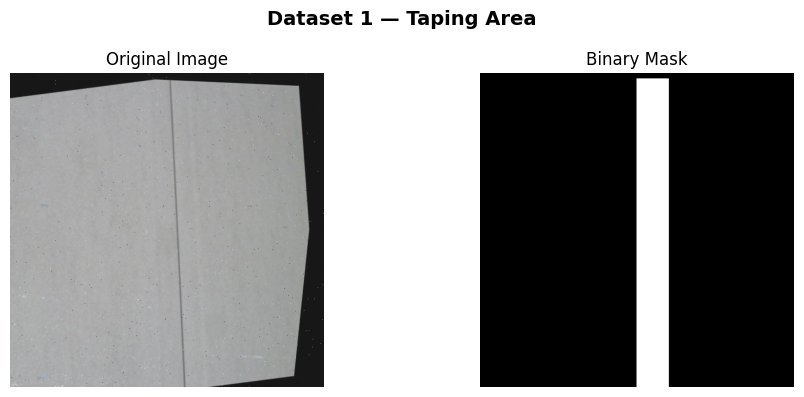

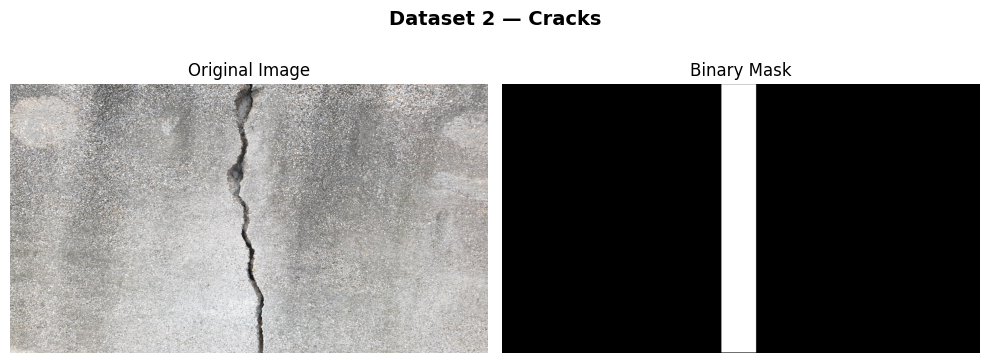

In [ ]:
import matplotlib.pyplot as plt

def show_sample(images_dir, masks_dir, title):
    # Get first image that has a matching mask
    img_files = [f for f in os.listdir(images_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in img_files:
        mask_file = os.path.splitext(img_file)[0] + '.png'
        mask_path = os.path.join(masks_dir, mask_file)
        if os.path.exists(mask_path):
            img = Image.open(os.path.join(images_dir, img_file)).convert('RGB')
            mask = Image.open(mask_path)

            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].imshow(img)
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(mask, cmap='gray')
            axes[1].set_title('Binary Mask')
            axes[1].axis('off')

            plt.suptitle(title, fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            break

# Dataset 1 - Taping
show_sample(
    f"{BASE}/data/dataset1_taping_raw/train",
    f"{BASE}/data/dataset1_taping/masks/train",
    "Dataset 1 — Taping Area"
)

# Dataset 2 - Cracks
show_sample(
    f"{BASE}/data/dataset2_cracks_raw/train",
    f"{BASE}/data/dataset2_cracks/masks/train",
    "Dataset 2 — Cracks"
)

Dataset Class

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as T

# Prompts for each class
PROMPTS = {
    'taping': [
        "segment taping area",
        "segment joint tape",
        "segment drywall seam",
        "segment wall joint"
    ],
    'crack': [
        "segment crack",
        "segment wall crack",
        "segment surface crack",
        "segment fracture"
    ]
}

class DrywallDataset(Dataset):
    def __init__(self, dataset1_imgs, dataset1_masks,
                       dataset2_imgs, dataset2_masks,
                       image_size=352):

        self.image_size = image_size
        self.samples = []

        # Load Dataset 1 (taping)
        if os.path.exists(dataset1_imgs) and os.path.exists(dataset1_masks):
            img_files = [f for f in os.listdir(dataset1_imgs)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for img_file in img_files:
                mask_file = os.path.splitext(img_file)[0] + '.png'
                mask_path = os.path.join(dataset1_masks, mask_file)
                if os.path.exists(mask_path):
                    self.samples.append({
                        'image': os.path.join(dataset1_imgs, img_file),
                        'mask':  mask_path,
                        'label': 'taping'
                    })

        # Load Dataset 2 (cracks)
        if os.path.exists(dataset2_imgs) and os.path.exists(dataset2_masks):
            img_files = [f for f in os.listdir(dataset2_imgs)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for img_file in img_files:
                mask_file = os.path.splitext(img_file)[0] + '.png'
                mask_path = os.path.join(dataset2_masks, mask_file)
                if os.path.exists(mask_path):
                    self.samples.append({
                        'image': os.path.join(dataset2_imgs, img_file),
                        'mask':  mask_path,
                        'label': 'crack'
                    })

        print(f"Dataset loaded: {len(self.samples)} total samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image and mask
        image = Image.open(sample['image']).convert('RGB')
        mask  = Image.open(sample['mask']).convert('L')

        # Resize both to same size
        image = image.resize((self.image_size, self.image_size), Image.BILINEAR)
        mask  = mask.resize((self.image_size, self.image_size), Image.NEAREST)

        # Convert to tensors
        image = T.ToTensor()(image)  # [3, H, W] float32
        mask  = torch.tensor(np.array(mask), dtype=torch.float32) / 255.0  # [H, W] 0-1

        # Pick a random prompt for this class
        prompt = random.choice(PROMPTS[sample['label']])

        return image, prompt, mask, sample['label']

print("Dataset class defined")

✅ Dataset class defined


Create DataLoaders

In [ ]:
# Dataset 1 paths
D1_TRAIN_IMGS  = f"{BASE}/data/dataset1_taping_raw/train"
D1_TRAIN_MASKS = f"{BASE}/data/dataset1_taping/masks/train"
D1_VALID_IMGS  = f"{BASE}/data/dataset1_taping_raw/valid"
D1_VALID_MASKS = f"{BASE}/data/dataset1_taping/masks/valid"

# Dataset 2 paths
D2_TRAIN_IMGS  = f"{BASE}/data/dataset2_cracks/images/train"
D2_TRAIN_MASKS = f"{BASE}/data/dataset2_cracks/masks/train_final"
D2_VALID_IMGS  = f"{BASE}/data/dataset2_cracks/images/valid"
D2_VALID_MASKS = f"{BASE}/data/dataset2_cracks/masks/valid"

# Create datasets
train_dataset = DrywallDataset(
    D1_TRAIN_IMGS, D1_TRAIN_MASKS,
    D2_TRAIN_IMGS, D2_TRAIN_MASKS,
    image_size=352
)

valid_dataset = DrywallDataset(
    D1_VALID_IMGS, D1_VALID_MASKS,
    D2_VALID_IMGS, D2_VALID_MASKS,
    image_size=352
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Valid batches: {len(valid_loader)}")

✅ Dataset loaded: 1927 total samples
✅ Dataset loaded: 498 total samples
✅ Train batches: 241
✅ Valid batches: 63


Quick Sanity Check

Image batch shape : torch.Size([8, 3, 352, 352])   ← should be [8, 3, 352, 352]
Mask batch shape  : torch.Size([8, 352, 352])    ← should be [8, 352, 352]
Sample prompts    : ('segment wall crack', 'segment crack', 'segment wall joint')
Sample labels     : ('crack', 'crack', 'taping')


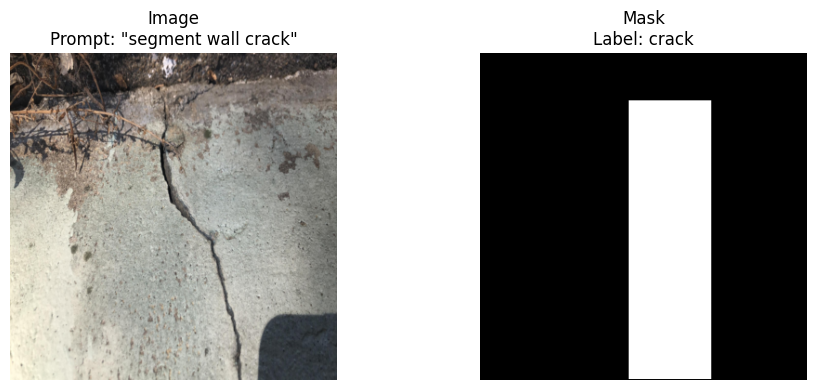

In [ ]:
images, prompts, masks, labels = next(iter(train_loader))

print(f"Image batch shape : {images.shape}   ← should be [8, 3, 352, 352]")
print(f"Mask batch shape  : {masks.shape}    ← should be [8, 352, 352]")
print(f"Sample prompts    : {prompts[:3]}")
print(f"Sample labels     : {labels[:3]}")

# Visualize one sample from the batch
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(images[0].permute(1, 2, 0))
axes[0].set_title(f'Image\nPrompt: "{prompts[0]}"')
axes[0].axis('off')
axes[1].imshow(masks[0], cmap='gray')
axes[1].set_title(f'Mask\nLabel: {labels[0]}')
axes[1].axis('off')
plt.tight_layout()
plt.show()

Load CLIPSeg Model

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

MODEL_NAME = "CIDAS/clipseg-rd64-refined"

processor = CLIPSegProcessor.from_pretrained(MODEL_NAME)
model     = CLIPSegForImageSegmentation.from_pretrained(MODEL_NAME)
model     = model.to(DEVICE)

# Freeze the CLIP encoder - only train the decoder
for name, param in model.named_parameters():
    if 'clip' in name.lower():
        param.requires_grad = False

# Count trainable parameters
total     = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   CLIPSeg loaded successfully")
print(f"   Total parameters     : {total:,}")
print(f"   Trainable parameters : {trainable:,}")
print(f"   Frozen parameters    : {total - trainable:,}")

preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/462 [00:00<?, ?it/s]

CLIPSegForImageSegmentation LOAD REPORT from: CIDAS/clipseg-rd64-refined
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
clip.text_model.embeddings.position_ids   | UNEXPECTED |  | 
clip.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ CLIPSeg loaded successfully
   Total parameters     : 150,747,746
   Trainable parameters : 1,127,009
   Frozen parameters    : 149,620,737


Define Loss & Metrics

In [ ]:
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1.0):
    pred   = torch.sigmoid(pred)
    pred   = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def bce_dice_loss(pred, target):
    # Resize pred to match target size
    if pred.shape != target.shape:
        pred = F.interpolate(
            pred.unsqueeze(1),
            size=target.shape[-2:],
            mode='bilinear',
            align_corners=False
        ).squeeze(1)
    bce  = F.binary_cross_entropy_with_logits(pred, target)
    dice = dice_loss(pred, target)
    return bce + dice   # Combined loss works best for segmentation

def compute_metrics(pred, target, threshold=0.5):
    pred   = torch.sigmoid(pred)
    if pred.shape != target.shape:
        pred = F.interpolate(
            pred.unsqueeze(1),
            size=target.shape[-2:],
            mode='bilinear',
            align_corners=False
        ).squeeze(1)
    pred_bin = (pred > threshold).float()

    # Intersection over Union
    intersection = (pred_bin * target).sum()
    union        = (pred_bin + target).clamp(0, 1).sum()
    iou          = (intersection + 1e-6) / (union + 1e-6)

    # Dice Score
    dice = (2 * intersection + 1e-6) / (pred_bin.sum() + target.sum() + 1e-6)

    return iou.item(), dice.item()

print("Loss functions and metrics defined")

✅ Loss functions and metrics defined


Training Loop

In [ ]:
EPOCHS    = 20
LR        = 1e-4
SAVE_PATH = f"{BASE}/checkpoints/clipseg_best.pt"

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR, weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS
)

best_iou = 0.0
history  = {'train_loss': [], 'val_loss': [], 'val_iou': [], 'val_dice': []}

print(f"Starting training for {EPOCHS} epochs...")
print(f"   Optimizer  : AdamW  (lr={LR})")
print(f"   Scheduler  : CosineAnnealingLR")
print(f"   Loss       : BCE + Dice")
print(f"   Checkpoint : {SAVE_PATH}")
print("=" * 50)

for epoch in range(EPOCHS):

    model.train()
    train_loss = 0.0

    for images, prompts, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)

        # Process inputs for CLIPSeg
        inputs = processor(
            text=list(prompts),
            images=[T.ToPILImage()(img.cpu()) for img in images],
            return_tensors="pt",
            padding=True
        ).to(DEVICE)

        # Forward pass
        outputs = model(**inputs)
        logits  = outputs.logits  # [B, H, W]

        # Compute loss
        loss = bce_dice_loss(logits, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ── Validation ────────────────────────────────
    model.eval()
    val_loss = 0.0
    val_iou  = 0.0
    val_dice = 0.0

    with torch.no_grad():
        for images, prompts, masks, _ in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]"):
            images = images.to(DEVICE)
            masks  = masks.to(DEVICE)

            inputs = processor(
                text=list(prompts),
                images=[T.ToPILImage()(img.cpu()) for img in images],
                return_tensors="pt",
                padding=True
            ).to(DEVICE)

            outputs = model(**inputs)
            logits  = outputs.logits

            loss       = bce_dice_loss(logits, masks)
            iou, dice  = compute_metrics(logits, masks)

            val_loss += loss.item()
            val_iou  += iou
            val_dice += dice

    val_loss /= len(valid_loader)
    val_iou  /= len(valid_loader)
    val_dice /= len(valid_loader)

    scheduler.step()

    # Save best model
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"   💾 New best model saved! (IoU: {best_iou:.4f})")

    # Log history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['val_dice'].append(val_dice)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val IoU: {val_iou:.4f} | "
          f"Val Dice: {val_dice:.4f}")

print("=" * 50)
print(f"Training complete! Best IoU: {best_iou:.4f}")

🚀 Starting training for 20 epochs...
   Optimizer  : AdamW  (lr=0.0001)
   Scheduler  : CosineAnnealingLR
   Loss       : BCE + Dice
   Checkpoint : /content/drive/MyDrive/drywall-qa/checkpoints/clipseg_best.pt


Epoch 1/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.37it/s]


   💾 New best model saved! (IoU: 0.4119)
Epoch 01/20 | Train Loss: 0.9063 | Val Loss: 0.7969 | Val IoU: 0.4119 | Val Dice: 0.5729


Epoch 2/20 [Valid]: 100%|██████████| 63/63 [00:25<00:00,  2.43it/s]


   💾 New best model saved! (IoU: 0.4952)
Epoch 02/20 | Train Loss: 0.6704 | Val Loss: 0.6726 | Val IoU: 0.4952 | Val Dice: 0.6581


Epoch 3/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


   💾 New best model saved! (IoU: 0.5188)
Epoch 03/20 | Train Loss: 0.6063 | Val Loss: 0.6309 | Val IoU: 0.5188 | Val Dice: 0.6791


Epoch 4/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.38it/s]


   💾 New best model saved! (IoU: 0.5221)
Epoch 04/20 | Train Loss: 0.5664 | Val Loss: 0.6118 | Val IoU: 0.5221 | Val Dice: 0.6822


Epoch 5/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.39it/s]


   💾 New best model saved! (IoU: 0.5487)
Epoch 05/20 | Train Loss: 0.5401 | Val Loss: 0.5799 | Val IoU: 0.5487 | Val Dice: 0.7047


Epoch 6/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.38it/s]


Epoch 06/20 | Train Loss: 0.5097 | Val Loss: 0.5772 | Val IoU: 0.5449 | Val Dice: 0.7019


Epoch 7/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.37it/s]


   💾 New best model saved! (IoU: 0.5701)
Epoch 07/20 | Train Loss: 0.4916 | Val Loss: 0.5455 | Val IoU: 0.5701 | Val Dice: 0.7230


Epoch 8/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.38it/s]


Epoch 08/20 | Train Loss: 0.4737 | Val Loss: 0.5543 | Val IoU: 0.5644 | Val Dice: 0.7187


Epoch 9/20 [Valid]: 100%|██████████| 63/63 [00:27<00:00,  2.31it/s]


   💾 New best model saved! (IoU: 0.5802)
Epoch 09/20 | Train Loss: 0.4616 | Val Loss: 0.5350 | Val IoU: 0.5802 | Val Dice: 0.7311


Epoch 10/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


   💾 New best model saved! (IoU: 0.5895)
Epoch 10/20 | Train Loss: 0.4513 | Val Loss: 0.5298 | Val IoU: 0.5895 | Val Dice: 0.7387


Epoch 11/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.38it/s]


   💾 New best model saved! (IoU: 0.5927)
Epoch 11/20 | Train Loss: 0.4427 | Val Loss: 0.5206 | Val IoU: 0.5927 | Val Dice: 0.7412


Epoch 12/20 [Valid]: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


Epoch 12/20 | Train Loss: 0.4296 | Val Loss: 0.5272 | Val IoU: 0.5818 | Val Dice: 0.7324


Epoch 13/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.38it/s]


   💾 New best model saved! (IoU: 0.5969)
Epoch 13/20 | Train Loss: 0.4235 | Val Loss: 0.5187 | Val IoU: 0.5969 | Val Dice: 0.7445


Epoch 14/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.38it/s]


Epoch 14/20 | Train Loss: 0.4186 | Val Loss: 0.5186 | Val IoU: 0.5955 | Val Dice: 0.7434


Epoch 15/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.37it/s]


Epoch 15/20 | Train Loss: 0.4138 | Val Loss: 0.5169 | Val IoU: 0.5960 | Val Dice: 0.7436


Epoch 16/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch 16/20 | Train Loss: 0.4091 | Val Loss: 0.5180 | Val IoU: 0.5952 | Val Dice: 0.7432


Epoch 17/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.36it/s]


   💾 New best model saved! (IoU: 0.5993)
Epoch 17/20 | Train Loss: 0.4067 | Val Loss: 0.5101 | Val IoU: 0.5993 | Val Dice: 0.7463


Epoch 18/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.39it/s]


Epoch 18/20 | Train Loss: 0.4040 | Val Loss: 0.5127 | Val IoU: 0.5984 | Val Dice: 0.7456


Epoch 19/20 [Valid]: 100%|██████████| 63/63 [00:26<00:00,  2.42it/s]


Epoch 19/20 | Train Loss: 0.4033 | Val Loss: 0.5164 | Val IoU: 0.5965 | Val Dice: 0.7441


Epoch 20/20 [Valid]: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]

Epoch 20/20 | Train Loss: 0.4018 | Val Loss: 0.5167 | Val IoU: 0.5967 | Val Dice: 0.7445
✅ Training complete! Best IoU: 0.5993


Plot Training Curves

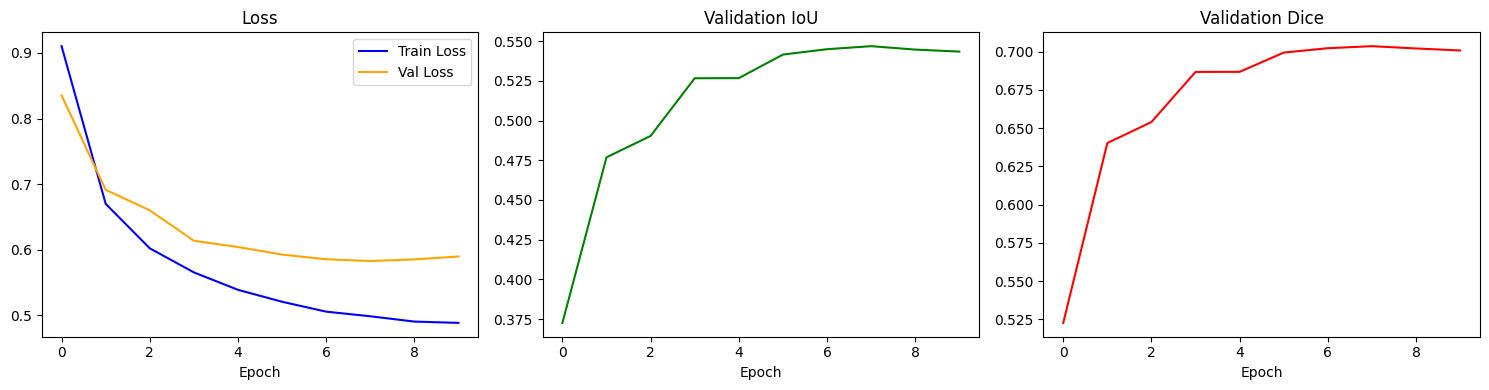

✅ Training curves saved to Drive


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'],   label='Val Loss',   color='orange')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history['val_iou'], color='green')
axes[1].set_title('Validation IoU')
axes[1].set_xlabel('Epoch')

axes[2].plot(history['val_dice'], color='red')
axes[2].set_title('Validation Dice')
axes[2].set_xlabel('Epoch')

plt.tight_layout()
plt.savefig(f"{BASE}/checkpoints/training_curves.png", dpi=150)
plt.show()
print("✅ Training curves saved to Drive")

Load Best Model

In [ ]:
# Load the best checkpoint we saved during training
model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
model.eval()
print("Best model loaded")

✅ Best model loaded


Per-Class Evaluation

In [ ]:
# Evaluate separately for taping and cracks
results = {
    'taping': {'iou': [], 'dice': []},
    'crack':  {'iou': [], 'dice': []}
}

model.eval()
with torch.no_grad():
    for images, prompts, masks, labels in tqdm(valid_loader, desc="Evaluating"):
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)

        inputs = processor(
            text=list(prompts),
            images=[T.ToPILImage()(img.cpu()) for img in images],
            return_tensors="pt",
            padding=True
        ).to(DEVICE)

        outputs = model(**inputs)
        logits  = outputs.logits

        # Evaluate each sample individually
        for i in range(len(images)):
            logit  = logits[i].unsqueeze(0)
            mask   = masks[i].unsqueeze(0)
            label  = labels[i]

            iou, dice = compute_metrics(logit, mask)
            results[label]['iou'].append(iou)
            results[label]['dice'].append(dice)

# Print results table
print("\n" + "=" * 50)
print(" PER-CLASS EVALUATION RESULTS")
print("=" * 50)
print(f"{'Class':<15} {'mIoU':>10} {'Dice':>10} {'Samples':>10}")
print("-" * 50)

all_ious  = []
all_dices = []

for label, metrics in results.items():
    miou  = np.mean(metrics['iou'])
    mdice = np.mean(metrics['dice'])
    n     = len(metrics['iou'])
    all_ious.extend(metrics['iou'])
    all_dices.extend(metrics['dice'])
    print(f"{label:<15} {miou:>10.4f} {mdice:>10.4f} {n:>10}")

print("-" * 50)
print(f"{'Overall':<15} {np.mean(all_ious):>10.4f} {np.mean(all_dices):>10.4f} {len(all_ious):>10}")
print("=" * 50)

Evaluating: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s]


       PER-CLASS EVALUATION RESULTS
Class                 mIoU       Dice    Samples
--------------------------------------------------
taping              0.5218     0.6727        250
crack               0.5676     0.7139        248
--------------------------------------------------
Overall             0.5446     0.6932        498


Save Prediction Masks

In [ ]:
import re

def save_prediction_masks(imgs_dir, masks_dir, label, prompt, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    img_files = [f for f in os.listdir(imgs_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    prompt_slug = prompt.replace(" ", "_")
    saved = 0

    for img_file in tqdm(img_files, desc=f"Saving {label} masks"):
        mask_file = os.path.splitext(img_file)[0] + '.png'
        if not os.path.exists(os.path.join(masks_dir, mask_file)):
            continue

        # Load and preprocess
        image = Image.open(os.path.join(imgs_dir, img_file)).convert('RGB')
        orig_size = image.size  # Save original size for resizing output

        inputs = processor(
            text=[prompt],
            images=[image],
            return_tensors="pt",
            padding=True
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)
            logits  = outputs.logits  # [1, H, W]

        # Convert to binary mask
        pred = torch.sigmoid(logits[0])
        pred = F.interpolate(
            pred.unsqueeze(0).unsqueeze(0),
            size=(orig_size[1], orig_size[0]),
            mode='bilinear',
            align_corners=False
        ).squeeze()

        binary_mask = (pred.cpu().numpy() > 0.5).astype(np.uint8) * 255

        # Save with required naming convention: id__prompt.png
        img_id   = os.path.splitext(img_file)[0]
        out_name = f"{img_id}__{prompt_slug}.png"
        Image.fromarray(binary_mask).save(os.path.join(output_dir, out_name))
        saved += 1

    print(f"✅ Saved {saved} masks for '{prompt}'")

PRED_DIR = f"{BASE}/predictions"

# Save taping predictions
save_prediction_masks(
    D1_VALID_IMGS, D1_VALID_MASKS,
    label="taping",
    prompt="segment taping area",
    output_dir=f"{PRED_DIR}/taping"
)

# Save crack predictions
save_prediction_masks(
    D2_VALID_IMGS, D2_VALID_MASKS,
    label="crack",
    prompt="segment crack",
    output_dir=f"{PRED_DIR}/cracks"
)

Saving taping masks: 100%|██████████| 250/250 [00:16<00:00, 15.06it/s]


✅ Saved 250 masks for 'segment taping area'


Saving crack masks: 100%|██████████| 248/248 [00:43<00:00,  5.71it/s]

✅ Saved 248 masks for 'segment crack'


Fix Prediction Mask Filenames

In [ ]:
def save_prediction_masks_fixed(imgs_dir, masks_dir, label, prompt, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    img_files = sorted([f for f in os.listdir(imgs_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    prompt_slug = prompt.replace(" ", "_")
    saved = 0

    for idx, img_file in enumerate(tqdm(img_files, desc=f"Saving {label} masks")):
        mask_file = os.path.splitext(img_file)[0] + '.png'
        if not os.path.exists(os.path.join(masks_dir, mask_file)):
            continue

        # Load image
        image     = Image.open(os.path.join(imgs_dir, img_file)).convert('RGB')
        orig_size = image.size

        inputs = processor(
            text=[prompt],
            images=[image],
            return_tensors="pt",
            padding=True
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)
            logits  = outputs.logits

        # Convert to binary mask
        pred = torch.sigmoid(logits[0])
        pred = F.interpolate(
            pred.unsqueeze(0).unsqueeze(0),
            size=(orig_size[1], orig_size[0]),
            mode='bilinear',
            align_corners=False
        ).squeeze()

        binary_mask = (pred.cpu().numpy() > 0.5).astype(np.uint8) * 255

        # Clean numeric ID + prompt slug
        # e.g. 0001__segment_crack.png
        img_id   = str(idx + 1).zfill(4)
        out_name = f"{img_id}__{prompt_slug}.png"

        Image.fromarray(binary_mask).save(os.path.join(output_dir, out_name))
        saved += 1

    print(f"✅ Saved {saved} masks  →  e.g. 0001__{prompt_slug}.png")


# Clear old predictions and re-save with clean names
import shutil
PRED_DIR = f"{BASE}/predictions"

for folder in [f"{PRED_DIR}/taping", f"{PRED_DIR}/cracks"]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# Taping
save_prediction_masks_fixed(
    D1_VALID_IMGS, D1_VALID_MASKS,
    label="taping",
    prompt="segment taping area",
    output_dir=f"{PRED_DIR}/taping"
)

# Cracks
save_prediction_masks_fixed(
    D2_VALID_IMGS, D2_VALID_MASKS,
    label="crack",
    prompt="segment crack",
    output_dir=f"{PRED_DIR}/cracks"
)


NameError: name 'PRED_DIR' is not defined

Visualize 4 Examples

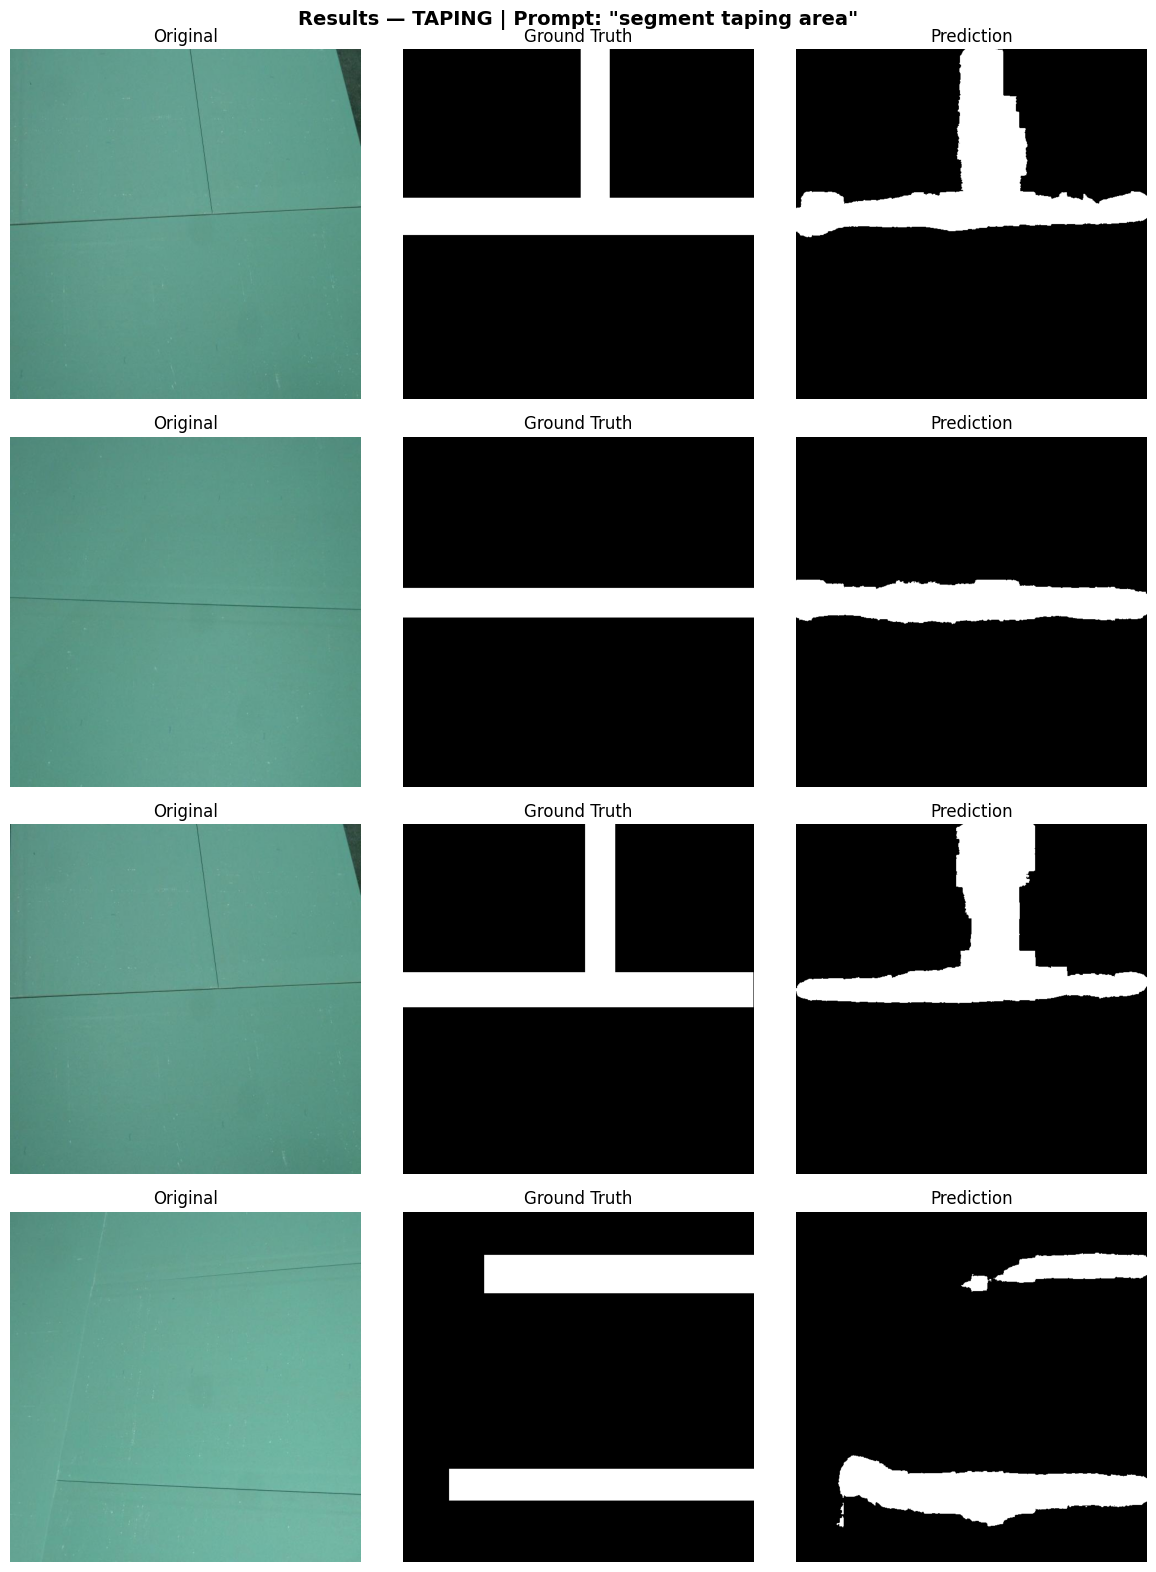

✅ Saved visualization to /content/drive/MyDrive/drywall-qa/predictions/taping_examples.png


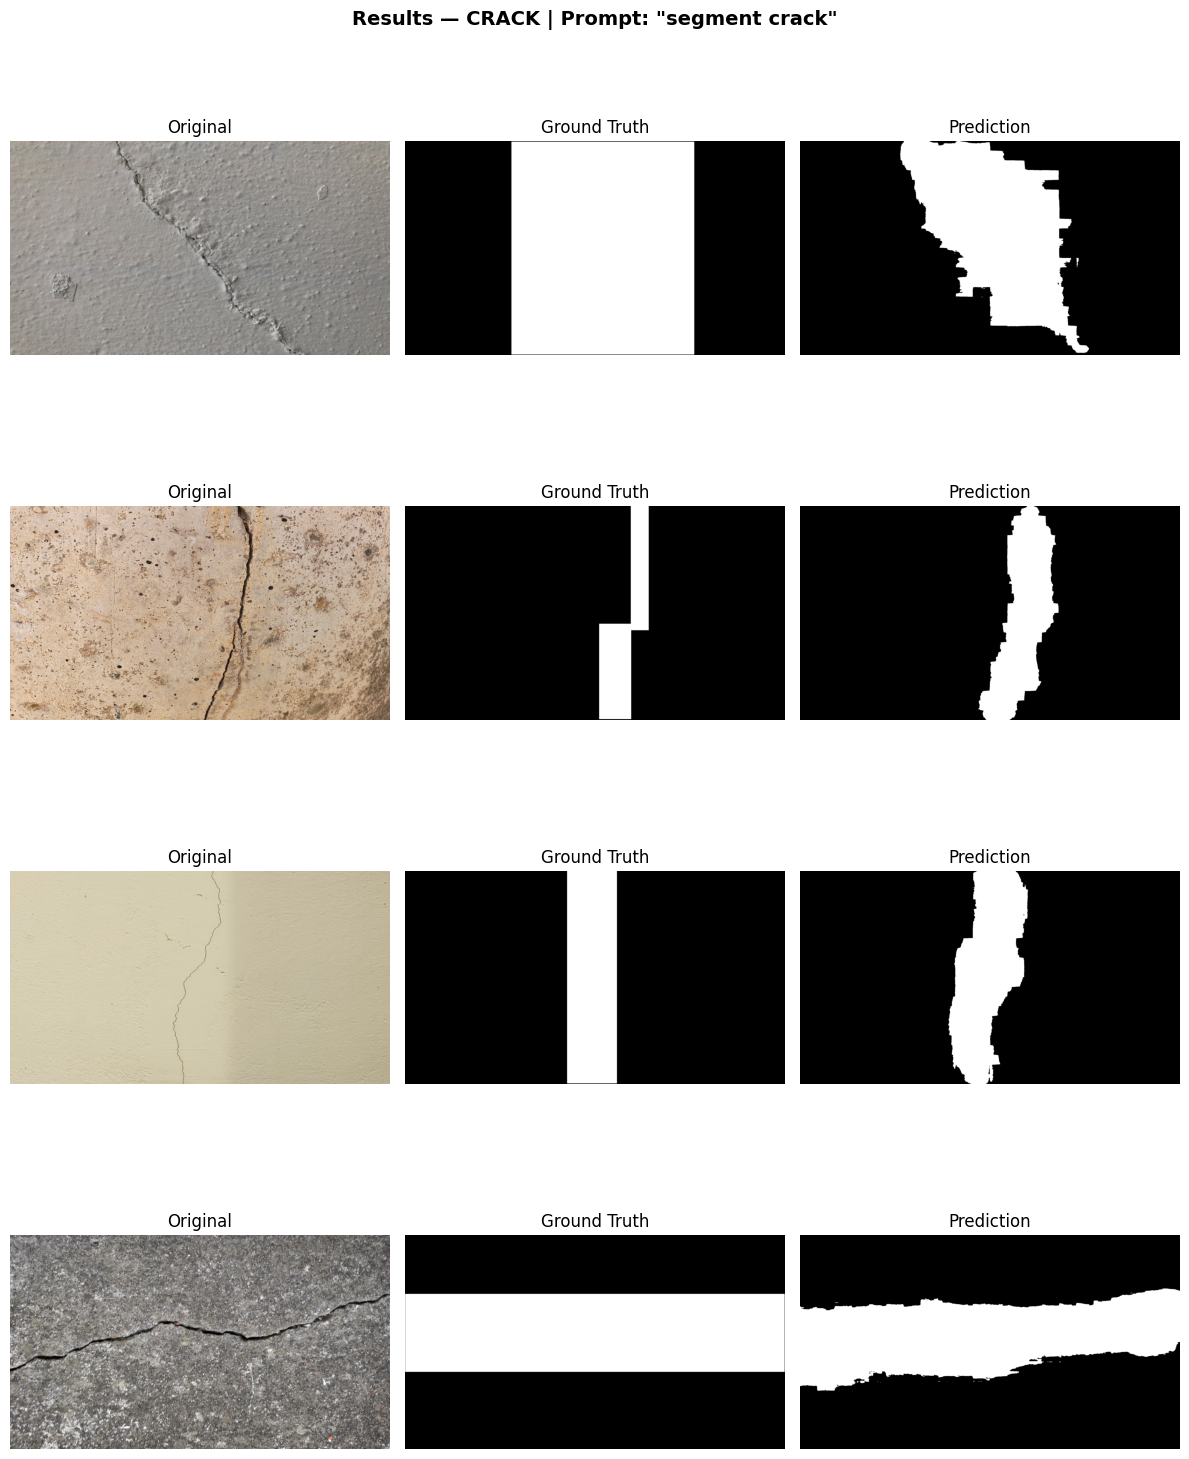

✅ Saved visualization to /content/drive/MyDrive/drywall-qa/predictions/crack_examples.png


In [ ]:
def visualize_examples(imgs_dir, masks_dir, pred_dir, prompt, label, n=4):
    prompt_slug = prompt.replace(" ", "_")
    img_files   = [f for f in os.listdir(imgs_dir)
                   if f.lower().endswith(('.jpg','.jpeg','.png'))][:n]

    fig, axes = plt.subplots(n, 3, figsize=(12, n * 4))
    fig.suptitle(f'Results — {label.upper()} | Prompt: "{prompt}"',
                 fontsize=14, fontweight='bold')

    for i, img_file in enumerate(img_files):
        img_id    = os.path.splitext(img_file)[0]
        mask_path = os.path.join(masks_dir, img_id + '.png')
        pred_path = os.path.join(pred_dir,  f"{img_id}__{prompt_slug}.png")

        if not os.path.exists(mask_path) or not os.path.exists(pred_path):
            continue

        img  = Image.open(os.path.join(imgs_dir, img_file)).convert('RGB')
        gt   = Image.open(mask_path)
        pred = Image.open(pred_path)

        axes[i][0].imshow(img);            axes[i][0].set_title('Original')
        axes[i][1].imshow(gt,  cmap='gray'); axes[i][1].set_title('Ground Truth')
        axes[i][2].imshow(pred, cmap='gray'); axes[i][2].set_title('Prediction')

        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout()
    save_path = f"{BASE}/predictions/{label}_examples.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved visualization to {save_path}")

# Taping examples
visualize_examples(
    D1_VALID_IMGS, D1_VALID_MASKS,
    f"{PRED_DIR}/taping",
    prompt="segment taping area",
    label="taping"
)

# Crack examples
visualize_examples(
    D2_VALID_IMGS, D2_VALID_MASKS,
    f"{PRED_DIR}/cracks",
    prompt="segment crack",
    label="crack"
)

Measure Inference Time

In [ ]:
import time

model.eval()
times = []

# Sample 20 images from validation set
sample_imgs = [f for f in os.listdir(D1_VALID_IMGS)
               if f.lower().endswith(('.jpg','.jpeg','.png'))][:20]

for img_file in sample_imgs:
    image = Image.open(os.path.join(D1_VALID_IMGS, img_file)).convert('RGB')

    inputs = processor(
        text=["segment taping area"],
        images=[image],
        return_tensors="pt",
        padding=True
    ).to(DEVICE)

    start = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end = time.time()

    times.append(end - start)

avg_time = np.mean(times)
print(f"Avg inference time per image: {avg_time:.4f} seconds")
print(f"   Min: {min(times):.4f}s  |  Max: {max(times):.4f}s")

✅ Avg inference time per image: 0.0220 seconds
   Min: 0.0188s  |  Max: 0.0526s
